In [2]:
import pandas as pd
import os

current_directory = os.getcwd()
print(f"\nCurrent working directory: {current_directory}\n")

#path_data = "Datasets\covid19-cough-audio-classification"
#filename = os.path.join(path_data, "metadata_compiled.csv")

path_data = "../vs_release_16k"
filename = os.path.join(path_data, "all_meta.csv")

data = pd.read_csv(filename, encoding="latin-1")


Current working directory: c:\Users\kevin\OneDrive - Hochschule Düsseldorf\MMI\Audio Data Science\GeoCougher



<Axes: ylabel='language'>

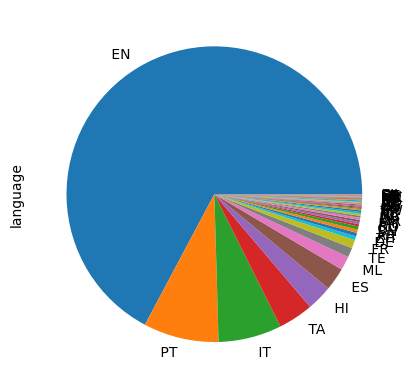

In [26]:
data.language.value_counts().plot(kind='pie')

In [3]:
data.head()

,ID,gender,age,country,language,sick
0,m0001,male,36,United States of America,EN,no
1,m0002,male,19,Italy,IT,yes
2,f0003,female,56,United States of America,EN,no
3,f0004,female,41,United States of America,EN,no
4,o0005,other,22,United States of America,EN,no


In [13]:
def get_dataframe_from_class_label(directory, class_label):
    files = os.listdir(directory)
    class_files = [file for file in files if class_label in file]
    # Create a DataFrame from class_files
    class_df = pd.DataFrame(class_files, columns=['filename'])

    # Extract the ID from the filename
    class_df['ID'] = class_df['filename'].str.extract('([a-z]\\d+)')
    # Merge class_df with data on the ID column

    merged_df = pd.merge(class_df, data, on='ID')
    return merged_df

<Axes: ylabel='language'>

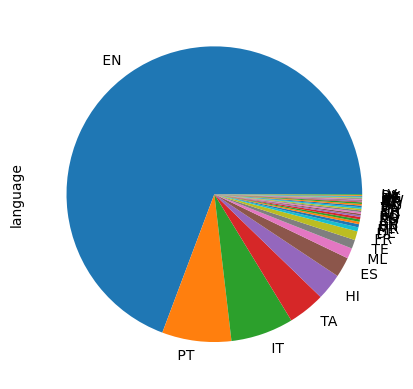

In [25]:
vocalsound_directory = "../vs_release_16k/audio_16k"
sneeze_data = get_dataframe_from_class_label(vocalsound_directory, "sneeze")
sneeze_data.language.value_counts().plot(kind='pie')

<Axes: ylabel='language'>

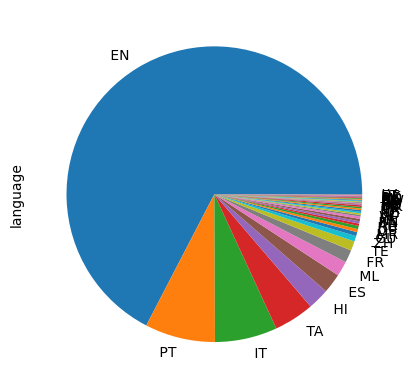

In [22]:
laughter_data = get_dataframe_from_class_label(vocalsound_directory, "laughter")
laughter_data.language.value_counts().plot(kind='pie')